# Chemutils

In [1]:
cd ./..

/Users/anpham/Documents/GitHub/icml18-jtnn


In [2]:
import os
from os import sys
sys.path.append('./jtnn')
import rdkit
import rdkit.Chem as Chem
from jtnn import *
# from .mol_tree import MolTree


In [3]:
# !pip install colorama
from colorama import Fore, Back, Style
print(Fore.RED + 'some red text')
print(Back.CYAN + 'and with a green background')
print(Style.DIM + 'and in dim text')
print(Style.RESET_ALL)
print('back to normal now')


some red text
and with a green background
and in dim text

back to normal now


==========benzynes==========


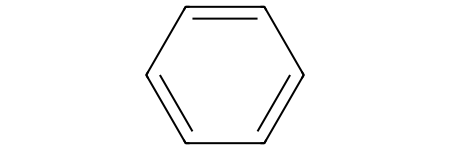

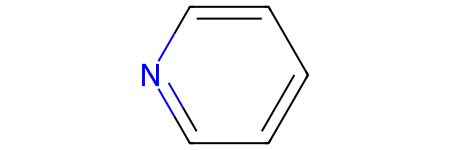

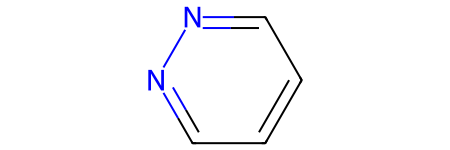

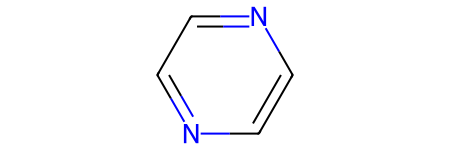

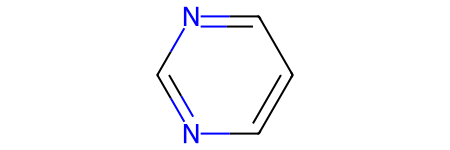

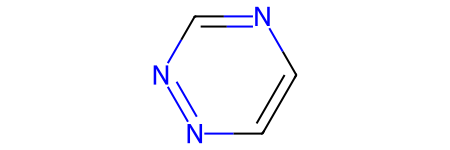

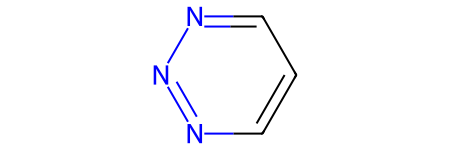

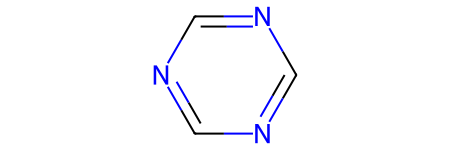

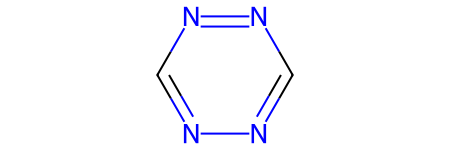

==========penzynes==========


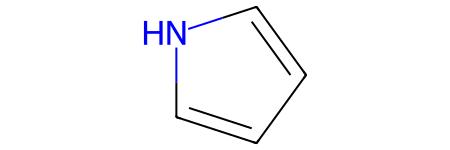

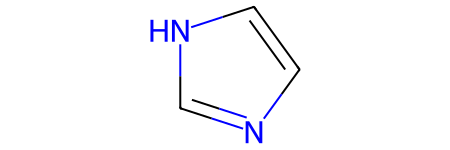

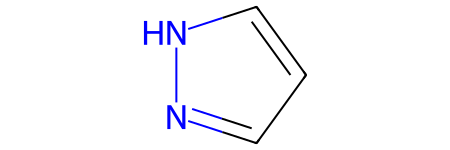

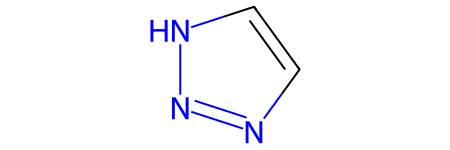

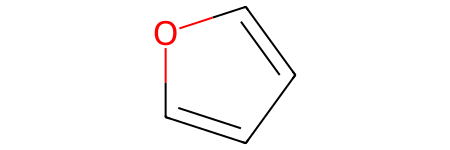

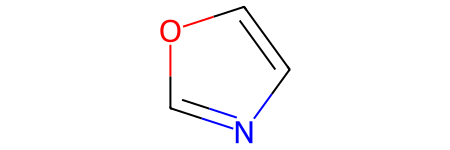

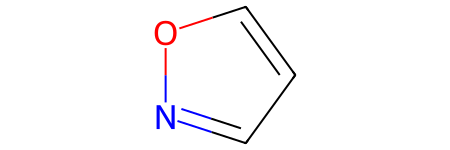

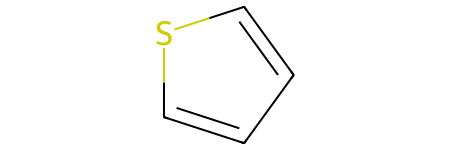

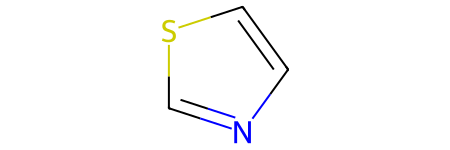

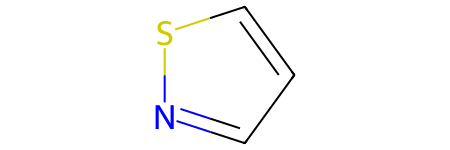

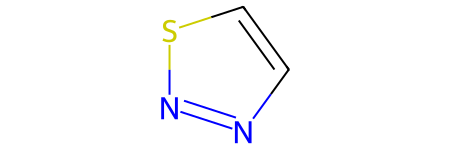

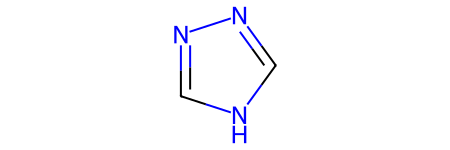

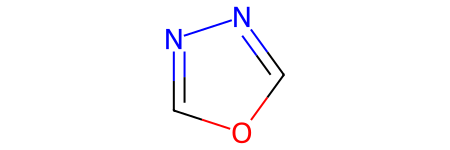

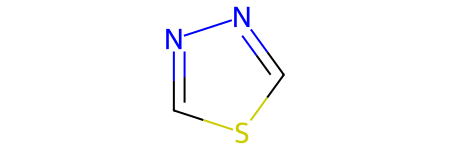

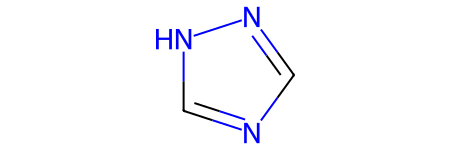

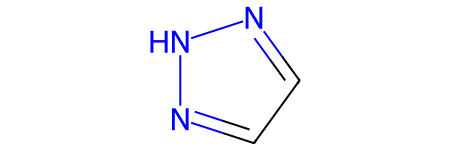

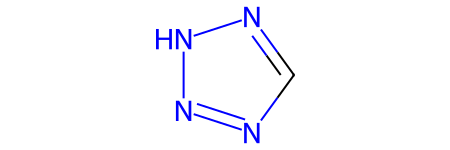

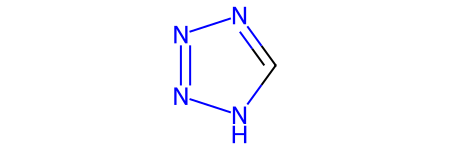

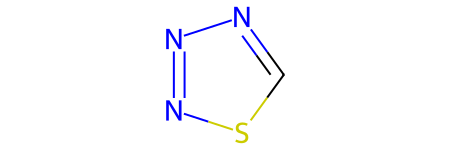

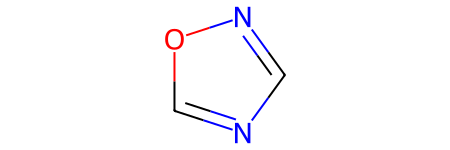

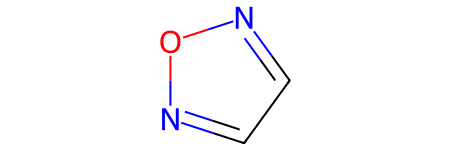

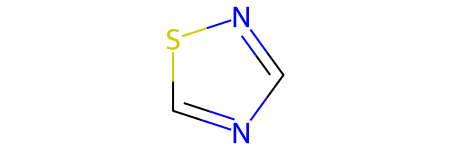

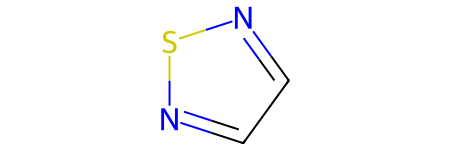

In [8]:
benzynes = ['C1=CC=CC=C1', 'C1=CC=NC=C1', 'C1=CC=NN=C1', 'C1=CN=CC=N1', 'C1=CN=CN=C1', 'C1=CN=NC=N1', 'C1=CN=NN=C1', 'C1=NC=NC=N1', 'C1=NN=CN=N1']
penzynes = ['C1=C[NH]C=C1', 'C1=C[NH]C=N1', 'C1=C[NH]N=C1', 'C1=C[NH]N=N1', 'C1=COC=C1', 'C1=COC=N1', 'C1=CON=C1', 'C1=CSC=C1', 'C1=CSC=N1', 'C1=CSN=C1', 'C1=CSN=N1', 'C1=NN=C[NH]1', 'C1=NN=CO1', 'C1=NN=CS1', 'C1=N[NH]C=N1', 'C1=N[NH]N=C1', 'C1=N[NH]N=N1', 'C1=NN=N[NH]1', 'C1=NN=NS1', 'C1=NOC=N1', 'C1=NON=C1', 'C1=NSC=N1', 'C1=NSN=C1']
print("="*10 + "benzynes" + "="*10)

for smiles in benzynes:
    display(Chem.MolFromSmiles(smiles))
print("="*10 + "penzynes" + "="*10)

for smiles in penzynes:
    display(Chem.MolFromSmiles(smiles))

In [1]:
from collections import defaultdict
import rdkit
import rdkit.Chem as Chem
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
MST_MAX_WEIGHT = 100
MAX_NCAND = 2000
import rdkit
import rdkit.Chem as Chem
import copy

def get_slots(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return [(atom.GetSymbol(), atom.GetFormalCharge(), atom.GetTotalNumHs()) for atom in mol.GetAtoms()]

class Vocab(object):
    benzynes = ['C1=CC=CC=C1', 'C1=CC=NC=C1', 'C1=CC=NN=C1', 'C1=CN=CC=N1', 'C1=CN=CN=C1', 'C1=CN=NC=N1', 'C1=CN=NN=C1', 'C1=NC=NC=N1', 'C1=NN=CN=N1']
    penzynes = ['C1=C[NH]C=C1', 'C1=C[NH]C=N1', 'C1=C[NH]N=C1', 'C1=C[NH]N=N1', 'C1=COC=C1', 'C1=COC=N1', 'C1=CON=C1', 'C1=CSC=C1', 'C1=CSC=N1', 'C1=CSN=C1', 'C1=CSN=N1', 'C1=NN=C[NH]1', 'C1=NN=CO1', 'C1=NN=CS1', 'C1=N[NH]C=N1', 'C1=N[NH]N=C1', 'C1=N[NH]N=N1', 'C1=NN=N[NH]1', 'C1=NN=NS1', 'C1=NOC=N1', 'C1=NON=C1', 'C1=NSC=N1', 'C1=NSN=C1']

    def __init__(self, smiles_list):
        self.vocab = smiles_list
        self.vmap = {x:i for i,x in enumerate(self.vocab)}
        self.slots = [get_slots(smiles) for smiles in self.vocab]
        Vocab.benzynes = [s for s in smiles_list if s.count('=') >= 2 and Chem.MolFromSmiles(s).GetNumAtoms() == 6] + ['C1=CCNCC1']
        Vocab.penzynes = [s for s in smiles_list if s.count('=') >= 2 and Chem.MolFromSmiles(s).GetNumAtoms() == 5] + ['C1=NCCN1','C1=NNCC1']
        
    def get_index(self, smiles):
        return self.vmap[smiles]

    def get_smiles(self, idx):
        return self.vocab[idx]

    def get_slots(self, idx):
        return copy.deepcopy(self.slots[idx])

    def size(self):
        return len(self.vocab)
def get_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: 
        return None
    Chem.Kekulize(mol)
    return mol
def get_smiles(mol):
    return Chem.MolToSmiles(mol, kekuleSmiles=True)

def set_atommap(mol, num=0):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(num)
def sanitize(mol):
    try:
        smiles = get_smiles(mol)
        mol = get_mol(smiles)
    except Exception as e:
        return None
    return mol

def copy_atom(atom):
    new_atom = Chem.Atom(atom.GetSymbol())
    new_atom.SetFormalCharge(atom.GetFormalCharge())
    new_atom.SetAtomMapNum(atom.GetAtomMapNum())
    return new_atom

def copy_edit_mol(mol):
    new_mol = Chem.RWMol(Chem.MolFromSmiles(''))
    for atom in mol.GetAtoms():
        new_atom = copy_atom(atom)
        new_mol.AddAtom(new_atom)
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()
        bt = bond.GetBondType()
        new_mol.AddBond(a1, a2, bt)
    return new_mol

def get_clique_mol(mol, atoms):
    smiles = Chem.MolFragmentToSmiles(mol, atoms, kekuleSmiles=True)
    new_mol = Chem.MolFromSmiles(smiles, sanitize=False)
    new_mol = copy_edit_mol(new_mol).GetMol()
    new_mol = sanitize(new_mol) #We assume this is not None
    return new_mol

def tree_decomp(mol):
    n_atoms = mol.GetNumAtoms()
    if n_atoms == 1: #special case
        return [[0]], []

    cliques = []                                #contain bonds not in rings with format [ [begin_atom1;end_atoms1],[begin_atom2;end_atoms2] ]
    for bond in mol.GetBonds():                     
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()
        if not bond.IsInRing():
            print("Have Bond")
            cliques.append([a1,a2])

    ssr = [list(x) for x in Chem.GetSymmSSSR(mol)]
    cliques.extend(ssr)

    nei_list = [[] for i in range(n_atoms)]                 #nei_list = sublist (represent for each atom) in a list
    for i in range(len(cliques)):
        for atom in cliques[i]:
            nei_list[atom].append(i)                        #each sublist contain the information clique order that atom at
            # print(f"nei_list at atom {i}, {nei_list}")

    print("cliq before merge:", cliques)
    print("nei_list before merge", nei_list)

    #Merge Rings with intersection > 2 atoms
    for i in range(len(cliques)):
        if len(cliques[i]) <= 2: continue                   #if this is bond => move to next 
        for atom in cliques[i]:
            for j in nei_list[atom]:
                if i >= j or len(cliques[j]) <= 2:     #If i>j reduce the double time check between two clique, which is redundancy
                    continue
                inter = set(cliques[i]) & set(cliques[j])
                if len(inter) > 2:
                    print("Have merging")
                    cliques[i].extend(cliques[j])
                    cliques[i] = list(set(cliques[i]))
                    cliques[j] = []
    #Clear back the nei_list after merging
    cliques = [c for c in cliques if len(c) > 0]
    nei_list = [[] for i in range(n_atoms)]
    for i in range(len(cliques)):
        for atom in cliques[i]:
            nei_list[atom].append(i)

    print('cliques after merge:', cliques)
    print('nei_list after merge:', nei_list)

    #Build edges and add singleton cliques
    edges = defaultdict(int)
    for atom in range(n_atoms):
        if len(nei_list[atom]) <= 1:                            #Ignore atom exist in only 1 clique
            continue
        cnei = nei_list[atom]
        bonds = [c for c in cnei if len(cliques[c]) == 2]       
        rings = [c for c in cnei if len(cliques[c]) > 4]
        print(f"atom {atom} has these bonds: {bonds}")
        print(f"atom {atom} has these ring: {rings}")
        
        if len(bonds) > 2 or (len(bonds) == 2 and len(cnei) > 2): #In general, if len(cnei) >= 3, a singleton should be added, but 1 bond + 2 ring is currently not dealt with.
            print(f"Add singleton by bonds")
            cliques.append([atom])
            c2 = len(cliques) - 1
            for c1 in cnei:
                edges[(c1,c2)] = 1
        elif len(rings) > 2: #Multiple (n>2) complex rings
            print(f"Add singleton by rings")
            cliques.append([atom])
            c2 = len(cliques) - 1
            for c1 in cnei:
                edges[(c1,c2)] = MST_MAX_WEIGHT - 1
        else:
            for i in range(len(cnei)):
                for j in range(i + 1, len(cnei)):
                    c1,c2 = cnei[i],cnei[j]
                    inter = set(cliques[c1]) & set(cliques[c2])
                    if edges[(c1,c2)] < len(inter):
                        edges[(c1,c2)] = len(inter) #cnei[i] < cnei[j] by construction
    print("cliques added singleton", cliques)
    print("edge dict:", edges)
    edges = [u + (MST_MAX_WEIGHT-v,) for u,v in edges.items()]
    if len(edges) == 0:
        return cliques, edges
    row,col,data = list(zip(*edges))
    n_clique = len(cliques)
    clique_graph = csr_matrix( (data,(row,col)), shape=(n_clique,n_clique) )        #Compressed Sparse Row matrix => just like a normal csv file
    junc_tree = minimum_spanning_tree(clique_graph)                                 # tree that connects all the cliques with the minimum total edge weight.
    row,col = junc_tree.nonzero()
    edges = [(row[i],col[i]) for i in range(len(row))]
    return (cliques, edges)
def enum_assemble(node, neighbors, prev_nodes=[], prev_amap=[]):
    all_attach_confs = []
    singletons = [nei_node.nid for nei_node in neighbors + prev_nodes if nei_node.mol.GetNumAtoms() == 1]

    def search(cur_amap, depth):
        if len(all_attach_confs) > MAX_NCAND:
            print(f'stop search due to MAX_NCAND ')
            return
        if depth == len(neighbors):
            all_attach_confs.append(cur_amap)
            print(f'depth end with {cur_amap}')
            return

        nei_node = neighbors[depth]
        print('\n'+"~"*10 + f'SEARCH NEIGHBOR {depth+1} with ID {nei_node.nid} contains {nei_node.clique}'+ "~"*10 +'\n')
        
        print(f'current amap a.k.a prev_amap: {cur_amap}')
        cand_amap = enum_attach(node.mol, nei_node, cur_amap, singletons)
        print(f"This is cand_amap of neighbors {depth+1} with id {nei_node.nid}: {cand_amap}")
        
        cand_smiles = set()
        candidates = []
        for amap in cand_amap:
            cand_mol = local_attach(node.mol, neighbors[:depth+1], prev_nodes, amap)
            cand_mol = sanitize(cand_mol)
            if cand_mol is None:
                continue
            smiles = get_smiles(cand_mol)
            if smiles in cand_smiles:
                continue
            print(f'amap {amap} has added to candidate')
            cand_smiles.add(smiles)
            candidates.append(amap)

        if len(candidates) == 0:
            return
        
        print(f"candidates after search neighbor {depth}: {(candidates)}")
        for idx,new_amap in enumerate(candidates):
            print('='*10 + f'Use  {candidates[idx]} to search with next neighbor ({depth+2})' + '='*10)
            search(new_amap, depth + 1)

    search(prev_amap, 0)
    cand_smiles = set()
    candidates = []
    aroma_score = []
    print(f"all_attach_confs of node {node.nid}: {all_attach_confs}")
    for amap in all_attach_confs:
        cand_mol = local_attach(node.mol, neighbors, prev_nodes, amap)
        cand_mol = Chem.MolFromSmiles(Chem.MolToSmiles(cand_mol))
        smiles = Chem.MolToSmiles(cand_mol)
        if smiles in cand_smiles or check_singleton(cand_mol, node, neighbors) == False:
            continue
        cand_smiles.add(smiles)
        print(f"added smiles {smiles} to cand_smiles")
        candidates.append( (smiles,amap) )
        aroma_score.append( check_aroma(cand_mol, node, neighbors) )
        print(f"aroma_score of amap {amap} is {check_aroma(cand_mol, node, neighbors)}")

    return candidates, aroma_score 
#This version records idx mapping between ctr_mol and nei_mol
def enum_attach(ctr_mol, nei_node, amap, singletons):
    print("="*10 + "Enum_attach" + "="*10)
    nei_mol,nei_idx = nei_node.mol,nei_node.nid
    att_confs = []
    black_list = [atom_idx for nei_id,atom_idx,_ in amap if nei_id in singletons]
    print(f'black_list of nei_index {nei_idx}: {black_list}')
    ctr_atoms = [atom for atom in ctr_mol.GetAtoms() if atom.GetIdx() not in black_list]
    ctr_atoms_smiles = [Chem.MolToSmiles(get_clique_mol(ctr_mol,[atom.GetIdx()])) for atom in ctr_mol.GetAtoms() if atom.GetIdx() not in black_list]

    print('atom of current node not in black_list: ', ctr_atoms_smiles)

    ctr_bonds = [bond for bond in ctr_mol.GetBonds()]
    
    if nei_mol.GetNumBonds() == 0: #neighbor singleton
        print(f"neighbor {nei_idx} is singleton")

        nei_atom = nei_mol.GetAtomWithIdx(0)
        used_list = [atom_idx for _,atom_idx,_ in amap]
        for atom in ctr_atoms:
            if atom_equal(atom, nei_atom) and atom.GetIdx() not in used_list:
                new_amap = amap + [(nei_idx, atom.GetIdx(), 0)]
                print(f"matched atom map {[(nei_idx, atom.GetIdx(), 0)]} is singleton")
                att_confs.append( new_amap )
   
    elif nei_mol.GetNumBonds() == 1: #neighbor is a bond
        bond = nei_mol.GetBondWithIdx(0)
        bond_val = int(bond.GetBondTypeAsDouble())
        b1,b2 = bond.GetBeginAtom(), bond.GetEndAtom()

        for atom in ctr_atoms: 
            #Optimize if atom is carbon (other atoms may change valence)
            if atom.GetAtomicNum() == 6 and atom.GetTotalNumHs() < bond_val:
                continue
            if atom_equal(atom, b1):
                new_amap = amap + [(nei_idx, atom.GetIdx(), b1.GetIdx())]
                print(f"matched atom map {[(nei_idx, atom.GetIdx(), b1.GetIdx())]} is bond")

                att_confs.append( new_amap )
            elif atom_equal(atom, b2):
                new_amap = amap + [(nei_idx, atom.GetIdx(), b2.GetIdx())]
                print(f"matched atom map {[(nei_idx, atom.GetIdx(), b2.GetIdx())]} is bond")

                att_confs.append( new_amap )
    else: 
        #intersection is an atom
        for a1 in ctr_atoms:
            for a2 in nei_mol.GetAtoms():
                if atom_equal(a1, a2):
                    #Optimize if atom is carbon (other atoms may change valence)
                    print(f"a1 have {a1.GetTotalNumHs()} hydro and a2 have {a2.GetTotalNumHs()} hydrogens")

                    if a1.GetAtomicNum() == 6 and a1.GetTotalNumHs() + a2.GetTotalNumHs() < 4:
                        continue
                    new_amap = amap + [(nei_idx, a1.GetIdx(), a2.GetIdx())]
                    print("intersection is an atom")
                    att_confs.append( new_amap )

        #intersection is an bond
        if ctr_mol.GetNumBonds() > 1:
            for b1 in ctr_bonds:
                for b2 in nei_mol.GetBonds():
                    if ring_bond_equal(b1, b2):
                        new_amap = amap + [(nei_idx, b1.GetBeginAtom().GetIdx(), b2.GetBeginAtom().GetIdx()), (nei_idx, b1.GetEndAtom().GetIdx(), b2.GetEndAtom().GetIdx())]
                        print("intersection is a bond")
                        att_confs.append( new_amap )

                    if ring_bond_equal(b1, b2, reverse=True):
                        new_amap = amap + [(nei_idx, b1.GetBeginAtom().GetIdx(), b2.GetEndAtom().GetIdx()), (nei_idx, b1.GetEndAtom().GetIdx(), b2.GetBeginAtom().GetIdx())]
                        att_confs.append( new_amap )
                        print("intersection is a bond")
    return att_confs

def local_attach(ctr_mol, neighbors, prev_nodes, amap_list):
    print('='*10 + 'Local_attach'+ '='*10)
    # display('Before attach_mols')
    # display(ctr_mol)
    ctr_mol = copy_edit_mol(ctr_mol)


    nei_amap = {nei.nid:{} for nei in prev_nodes + neighbors}

    for nei_id,ctr_atom,nei_atom in amap_list:
        nei_amap[nei_id][nei_atom] = ctr_atom
    print(f' nei_amap in local_attach: {nei_amap}')    

    ctr_mol = attach_mols(ctr_mol, neighbors, prev_nodes, nei_amap)
    display(f'After attach_mols:')
    display(ctr_mol)                
    return ctr_mol.GetMol()
def attach_mols(ctr_mol, neighbors, prev_nodes, nei_amap):
    print('='*10 + 'Attach_mol'+ '='*10)
    prev_nids = [node.nid for node in prev_nodes]
    for nei_node in prev_nodes + neighbors:
        nei_id,nei_mol = nei_node.nid,nei_node.mol
        print(F'THIS IS ID of NODE Below: {nei_node.nid}')
        display(nei_node.mol)
        amap = nei_amap[nei_id]
        print(f"amap in attach_mols: {amap}")
        for atom in nei_mol.GetAtoms():
            if atom.GetIdx() not in amap:
                new_atom = copy_atom(atom)
                amap[atom.GetIdx()] = ctr_mol.AddAtom(new_atom)
                print(f'added_atom {atom.GetIdx()}')

        if nei_mol.GetNumBonds() == 0:
            nei_atom = nei_mol.GetAtomWithIdx(0)
            ctr_atom = ctr_mol.GetAtomWithIdx(amap[0])
            ctr_atom.SetAtomMapNum(nei_atom.GetAtomMapNum())                #SET THE SINGLETON TO THE MATCHED IN CURRENT MOL
        else:
            for bond in nei_mol.GetBonds():
                a1 = amap[bond.GetBeginAtom().GetIdx()]
                a2 = amap[bond.GetEndAtom().GetIdx()]
                if ctr_mol.GetBondBetweenAtoms(a1, a2) is None:
                    ctr_mol.AddBond(a1, a2, bond.GetBondType())
                elif nei_id in prev_nids: #father node overrides
                    ctr_mol.RemoveBond(a1, a2)
                    ctr_mol.AddBond(a1, a2, bond.GetBondType()) 
   
    return ctr_mol
    
def atom_equal(a1, a2):
    return a1.GetSymbol() == a2.GetSymbol() and a1.GetFormalCharge() == a2.GetFormalCharge()

#Bond type not considered because all aromatic (so SINGLE matches DOUBLE)
def ring_bond_equal(b1, b2, reverse=False):
    b1 = (b1.GetBeginAtom(), b1.GetEndAtom())
    if reverse:
        b2 = (b2.GetEndAtom(), b2.GetBeginAtom())
    else:
        b2 = (b2.GetBeginAtom(), b2.GetEndAtom())
    return atom_equal(b1[0], b2[0]) and atom_equal(b1[1], b2[1])

def check_singleton(cand_mol, ctr_node, nei_nodes):
    """cand_mol: iterate from amap in all_attach_conformations
       ctr_node: current node
       nei_nodes: ALL neighbor nodes"""
    rings = [node for node in nei_nodes + [ctr_node] if node.mol.GetNumAtoms() > 2]
    singletons = [node for node in nei_nodes + [ctr_node] if node.mol.GetNumAtoms() == 1]
    if len(singletons) > 0 or len(rings) == 0: return True

    n_leaf2_atoms = 0
    for atom in cand_mol.GetAtoms():
        nei_leaf_atoms = [a for a in atom.GetNeighbors() if not a.IsInRing()] #a.GetDegree() == 1]
        if len(nei_leaf_atoms) > 1: 
            n_leaf2_atoms += 1

    return n_leaf2_atoms == 0

def check_aroma(cand_mol, ctr_node, nei_nodes):
    rings = [node for node in nei_nodes + [ctr_node] if node.mol.GetNumAtoms() >= 3]
    if len(rings) < 2: return 0 #Only multi-ring system needs to be checked

    get_nid = lambda x: 0 if x.is_leaf else x.nid
    benzynes = [get_nid(node) for node in nei_nodes + [ctr_node] if node.smiles in Vocab.benzynes] 
    penzynes = [get_nid(node) for node in nei_nodes + [ctr_node] if node.smiles in Vocab.penzynes] 
    if len(benzynes) + len(penzynes) == 0: 
        return 0 #No specific aromatic rings

    n_aroma_atoms = 0
    for atom in cand_mol.GetAtoms():
        if atom.GetAtomMapNum() in benzynes+penzynes and atom.GetIsAromatic():
            n_aroma_atoms += 1

    if n_aroma_atoms >= len(benzynes) * 4 + len(penzynes) * 3:
        return 1000
    else:
        return -0.001 

In [2]:
import sys
import rdkit
import rdkit.Chem as Chem
sys.path.append('./fast_jtnn')
# from vocab import *

class MolTreeNode(object):

    def __init__(self, smiles, clique=[]):
        self.smiles = smiles
        self.mol = get_mol(self.smiles)

        self.clique = [x for x in clique] #copy
        self.neighbors = []
        
    def add_neighbor(self, nei_node):
        self.neighbors.append(nei_node)

    def recover(self, original_mol):
        clique = []
        clique.extend(self.clique)
        if not self.is_leaf:                                                
            for cidx in self.clique:
                original_mol.GetAtomWithIdx(cidx).SetAtomMapNum(self.nid)    #set the substruct attach to the id of node set in line 91

        for nei_node in self.neighbors:        
                                          #neighbors contain node neighbor
            
            if nei_node.is_leaf: #Leaf node, no need to mark 
                continue
            

            for cidx in nei_node.clique:                                     #call node.clique is the clique in line 12
                

                #allow singleton node override the atom mapping                 #A singleton node refers to a node in the clique that forms a clique by itself (contains only one atom).
                if cidx not in self.clique or len(nei_node.clique) == 1:        #check idx in clique of neighbor node not in the current node or just a singleton 
                    atom = original_mol.GetAtomWithIdx(cidx)
                    atom.SetAtomMapNum(nei_node.nid)
        # for atom in original_mol.GetAtoms():
        #     atom.SetProp('atomLabel', str(atom.GetIdx()))


        clique = list(set(clique))                                                              #not too clearly
        label_mol = get_clique_mol(original_mol, clique)
        # for atom in label_mol.GetAtoms():
        #     # For each atom, set the property "atomNote" to a index+1 of the atom
        #     atom.SetProp("atomNote", str(atom.GetIdx()))

        self.label = Chem.MolToSmiles(Chem.MolFromSmiles(get_smiles(label_mol)))


        for cidx in clique:
            original_mol.GetAtomWithIdx(cidx).SetAtomMapNum(0)

        return self.label
    
    def assemble(self):
        neighbors = [nei for nei in self.neighbors if nei.mol.GetNumAtoms() > 1]
        neighbors = sorted(neighbors, key=lambda x:x.mol.GetNumAtoms(), reverse=True)
        singletons = [nei for nei in self.neighbors if nei.mol.GetNumAtoms() == 1]
        neighbors = singletons + neighbors

        cands,aroma = enum_assemble(self, neighbors)
        new_cands = [cand for i,cand in enumerate(cands) if aroma[i] >= 0]
        if len(new_cands) > 0: cands = new_cands

        if len(cands) > 0:
            self.cands, _ = list(zip(*cands))
            self.cands = list(self.cands)
        else:
            self.cands = []

class MolTree(object):

    def __init__(self, smiles):
        self.smiles = smiles
        self.mol = get_mol(smiles)

        #Stereo Generation (currently disabled)
        #mol = Chem.MolFromSmiles(smiles)
        #self.smiles3D = Chem.MolToSmiles(mol, isomericSmiles=True)
        #self.smiles2D = Chem.MolToSmiles(mol)
        #self.stereo_cands = decode_stereo(self.smiles2D)

        cliques, edges = tree_decomp(self.mol)                              #tree_decompose in chemutils.py
        self.nodes = []
        root = 0
        for i,c in enumerate(cliques):
            cmol = get_clique_mol(self.mol, c)                              #get the mol of each clique
            node = MolTreeNode(get_smiles(cmol), c)
            self.nodes.append(node)
            if min(c) == 0: root = i                                        #finding root node by find clique contain atom has index 0 

        for x,y in edges:                                                   #edge contain index of clique that connected
            self.nodes[x].add_neighbor(self.nodes[y])
            self.nodes[y].add_neighbor(self.nodes[x])
        
        if root > 0:                                                        #ensuring that the identified root node is positioned at index 0 in the self.nodes
            self.nodes[0],self.nodes[root] = self.nodes[root],self.nodes[0] #swaps the positions of these two nodes

        for i,node in enumerate(self.nodes):
            node.nid = i + 1
            if len(node.neighbors) > 1: #Leaf node mol is not marked
                set_atommap(node.mol, node.nid)                             #Set the ID of each node (the mol of each clique), no neighbor = leaf
            node.is_leaf = (len(node.neighbors) == 1)

    def size(self):
        return len(self.nodes)

    def recover(self):
        for  node in self.nodes:
            node.recover(self.mol)                                          #recover in Mol_Tree Node


    def assemble(self):
        print("="*10 + "ASSEMBLE" + "="*10)
        for node in self.nodes:
            print(Fore.RED+ Back.CYAN+'='*5 + f'THIS IS NODE {node.nid} WITH {len(node.neighbors)} NEIGHBORS ' + '='*5)
            display(node.mol)
            node.assemble()

def dfs(node, fa_idx):
    max_depth = 0
    for child in node.neighbors:
        if child.idx == fa_idx: continue
        max_depth = max(max_depth, dfs(child, node.idx))
    return max_depth + 1


# if __name__ == "__main__":
#     import sys
#     lg = rdkit.RDLogger.logger() 
#     lg.setLevel(rdkit.RDLogger.CRITICAL)

#     cset = set()
#     for line in sys.stdin:
#         smiles = line.split()[0]
#         mol = MolTree(smiles)
#         for c in mol.nodes:
#             cset.add(c.smiles)
#     for x in cset:
#         print(x)



# Mol_tree

In [159]:
# import sys
# import rdkit
# import rdkit.Chem as Chem
# sys.path.append('./fast_jtnn')
# # from vocab import *

# class MolTreeNode(object):

#     def __init__(self, smiles, clique=[]):
#         self.smiles = smiles
#         self.mol = get_mol(self.smiles)

#         self.clique = [x for x in clique] #copy
#         self.neighbors = []
        
#     def add_neighbor(self, nei_node):
#         self.neighbors.append(nei_node)

#     def recover(self, original_mol):
#         clique = []
#         clique.extend(self.clique)
#         if not self.is_leaf:                                                
#             for cidx in self.clique:
#                 original_mol.GetAtomWithIdx(cidx).SetAtomMapNum(self.nid)    #set the substruct attach to the id of node set in line 91

#         for nei_node in self.neighbors:        
#                                           #neighbors contain node neighbor
#             print(f'This is neighbor with id {nei_node.nid}')
#             display(nei_node.mol)
            
#             if nei_node.is_leaf: #Leaf node, no need to mark 
#                 continue
            
#             print(f'nei_node clique contain: {nei_node.clique}')
#             print(f'node clique contain: {self.clique}')
            
#             for cidx in nei_node.clique:                                     #call node.clique is the clique in line 12
                
#                 print(f'atom neighbor {cidx} in current node: {cidx in self.clique} ; neighbor is singleton: {len(nei_node.clique) ==1}')

#                 #allow singleton node override the atom mapping                 #A singleton node refers to a node in the clique that forms a clique by itself (contains only one atom).
#                 if cidx not in self.clique or len(nei_node.clique) == 1:        #check idx in clique of neighbor node not in the current node or just a singleton 
#                     atom = original_mol.GetAtomWithIdx(cidx)
#                     atom.SetAtomMapNum(nei_node.nid)
#         # for atom in original_mol.GetAtoms():
#         #     atom.SetProp('atomLabel', str(atom.GetIdx()))
#         display(f'Original mol after set atom map:')
#         display(original_mol)

#         clique = list(set(clique))                                                              #not too clearly
#         label_mol = get_clique_mol(original_mol, clique)
#         # for atom in label_mol.GetAtoms():
#         #     # For each atom, set the property "atomNote" to a index+1 of the atom
#         #     atom.SetProp("atomNote", str(atom.GetIdx()))

#         self.label = Chem.MolToSmiles(Chem.MolFromSmiles(get_smiles(label_mol)))
#         display(f'The label of node {self.nid} is: {self.label}, represent below')

#         display(label_mol)

#         for cidx in clique:
#             original_mol.GetAtomWithIdx(cidx).SetAtomMapNum(0)

#         return self.label
    
#     def assemble(self):
#         neighbors = [nei for nei in self.neighbors if nei.mol.GetNumAtoms() > 1]
#         neighbors = sorted(neighbors, key=lambda x:x.mol.GetNumAtoms(), reverse=True)
#         singletons = [nei for nei in self.neighbors if nei.mol.GetNumAtoms() == 1]
#         neighbors = singletons + neighbors

#         cands,aroma = enum_assemble(self, neighbors)
#         new_cands = [cand for i,cand in enumerate(cands) if aroma[i] >= 0]
#         if len(new_cands) > 0: cands = new_cands

#         if len(cands) > 0:
#             self.cands, _ = list(zip(*cands))
#             self.cands = list(self.cands)
#         else:
#             self.cands = []

# class MolTree(object):

#     def __init__(self, smiles):
#         self.smiles = smiles
#         self.mol = get_mol(smiles)

#         #Stereo Generation (currently disabled)
#         #mol = Chem.MolFromSmiles(smiles)
#         #self.smiles3D = Chem.MolToSmiles(mol, isomericSmiles=True)
#         #self.smiles2D = Chem.MolToSmiles(mol)
#         #self.stereo_cands = decode_stereo(self.smiles2D)

#         cliques, edges = tree_decomp(self.mol)                              #tree_decompose in chemutils.py
#         self.nodes = []
#         root = 0
#         for i,c in enumerate(cliques):
#             cmol = get_clique_mol(self.mol, c)                              #get the mol of each clique
#             node = MolTreeNode(get_smiles(cmol), c)
#             self.nodes.append(node)
#             if min(c) == 0: root = i                                        #finding root node by find clique contain atom has index 0 

#         for x,y in edges:                                                   #edge contain index of clique that connected
#             self.nodes[x].add_neighbor(self.nodes[y])
#             self.nodes[y].add_neighbor(self.nodes[x])
        
#         if root > 0:                                                        #ensuring that the identified root node is positioned at index 0 in the self.nodes
#             self.nodes[0],self.nodes[root] = self.nodes[root],self.nodes[0] #swaps the positions of these two nodes

#         for i,node in enumerate(self.nodes):
#             node.nid = i + 1
#             if len(node.neighbors) > 1: #Leaf node mol is not marked
#                 set_atommap(node.mol, node.nid)                             #Set the ID of each node (the mol of each clique), no neighbor = leaf
#             node.is_leaf = (len(node.neighbors) == 1)

#     def size(self):
#         return len(self.nodes)

#     def recover(self):
#         print("="*10 + "Recover" + "="*10)
#         for  node in self.nodes:
#             print('='*5 + f'THIS IS NODE {node.nid} WITH {len(node.neighbors)} NEIGHBORS ' + '='*5)
#             node.recover(self.mol)                                          #recover in Mol_Tree Node


#     def assemble(self):
#         print("="*10 + "ASSEMBLE" + "="*10)
#         for node in self.nodes:
#             print('='*5 + f'THIS IS NODE {node.nid} WITH {len(node.neighbors)} NEIGHBORS ' + '='*5)
#             display(node.mol)
#             node.assemble()

# def dfs(node, fa_idx):
#     max_depth = 0
#     for child in node.neighbors:
#         if child.idx == fa_idx: continue
#         max_depth = max(max_depth, dfs(child, node.idx))
#     return max_depth + 1


# # if __name__ == "__main__":
# #     import sys
# #     lg = rdkit.RDLogger.logger() 
# #     lg.setLevel(rdkit.RDLogger.CRITICAL)

# #     cset = set()
# #     for line in sys.stdin:
# #         smiles = line.split()[0]
# #         mol = MolTree(smiles)
# #         for c in mol.nodes:
# #             cset.add(c.smiles)
# #     for x in cset:
# #         print(x)



# Preprocess

In [9]:
# import torch
# import torch.nn as nn
from multiprocessing import Pool

import math, random, sys
from optparse import OptionParser
import pickle as pickle

# from fast_jtnn import *
import rdkit

def tensorize(smiles, assm=True):
    mol_tree = MolTree(smiles)              #class MolTree in ./fast_jtnn/mol_tree.py => use function in ./fast_jtnn/chemutils.py
    mol_tree.recover()
    if assm:
        mol_tree.assemble()
        for node in mol_tree.nodes:
            print('\n'+ '='*5 + f'THIS IS NODE {node.nid} WITH node.label = {node.label} and node.cands = {node.cands}' '='*5 + "\n")

            if node.label not in node.cands:
                print(f"node.label not in node.cands")
                node.cands.append(node.label)

    del mol_tree.mol
    for node in mol_tree.nodes:
        del node.mol

    return mol_tree

a=tensorize('CN1C2CCC1CC(C2)OC(=O)C(CO)c3ccccc3',assm=True)
display(a.mol)

[12:14:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:14:00] Explicit valence for atom # 1 C, 5, is greater than permitted



=====THIS IS NODE 1 WITH node.label = CN1[CH:9]2[CH2:9][CH2:9][CH2:9][CH:9]1[CH2:9][CH2:9]2 and node.cands = ['NC1[CH2:9][CH:9]2[CH2:9][CH2:9][CH:9]([CH2:9]1)[NH:9]2', 'NC1[CH2:9][CH2:9][CH:9]2[CH2:9][CH2:9][CH:9]1[NH:9]2', 'NC12[CH2:9][CH2:9][CH2:9][CH:9]([CH2:9][CH2:9]1)[NH:9]2', 'NC1[CH2:9][CH:9]2[CH2:9][CH2:9][CH2:9][CH:9]1[NH:9]2', 'CN1[CH:9]2[CH2:9][CH2:9][CH2:9][CH:9]1[CH2:9][CH2:9]2']=THIS IS NODE 1 WITH node.label = CN1[CH:9]2[CH2:9][CH2:9][CH2:9][CH:9]1[CH2:9][CH2:9]2 and node.cands = ['NC1[CH2:9][CH:9]2[CH2:9][CH2:9][CH:9]([CH2:9]1)[NH:9]2', 'NC1[CH2:9][CH2:9][CH:9]2[CH2:9][CH2:9][CH:9]1[NH:9]2', 'NC12[CH2:9][CH2:9][CH2:9][CH:9]([CH2:9][CH2:9]1)[NH:9]2', 'NC1[CH2:9][CH:9]2[CH2:9][CH2:9][CH2:9][CH:9]1[NH:9]2', 'CN1[CH:9]2[CH2:9][CH2:9][CH2:9][CH:9]1[CH2:9][CH2:9]2']=THIS IS NODE 1 WITH node.label = CN1[CH:9]2[CH2:9][CH2:9][CH2:9][CH:9]1[CH2:9][CH2:9]2 and node.cands = ['NC1[CH2:9][CH:9]2[CH2:9][CH2:9][CH:9]([CH2:9]1)[NH:9]2', 'NC1[CH2:9][CH2:9][CH:9]2[CH2:9][CH2:9][CH:9]1[NH

AttributeError: 'MolTree' object has no attribute 'mol'

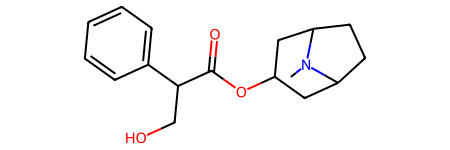

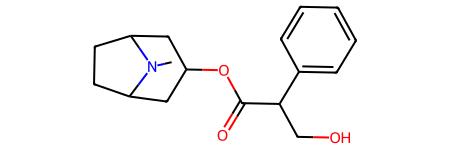

In [86]:
def copy_atom(atom):
    new_atom = Chem.Atom(atom.GetSymbol())
    new_atom.SetFormalCharge(atom.GetFormalCharge())
    new_atom.SetAtomMapNum(atom.GetAtomMapNum())
    return new_atom

def copy_edit_mol(mol):
    new_mol = Chem.RWMol(Chem.MolFromSmiles(''))
    display(mol)
    for atom in mol.GetAtoms():
        new_atom = copy_atom(atom)
        new_mol.AddAtom(new_atom)
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()
        bt = bond.GetBondType()
        new_mol.AddBond(a1, a2, bt)
    # display(new_mol)
    return new_mol

smiles = "CN1C2CCC1CC(C2)OC(=O)C(CO)c3ccccc3"   #have_bond_merge
mol = Chem.MolFromSmiles(smiles)
test = copy_edit_mol(mol)
test

In [15]:
from rdkit import Chem

# Create a molecule with multiple rings (naphthalene)
# smiles = 'c1ccc2c(c1)ccc3c2cccc3'  # SMILES notation for naphthalene
smiles = "CN1C2CCC1CC(C2)OC(=O)C(CO)c3ccccc3"   #have_bond_merge
# smiles = "O=C1N(CCCCN2CCN(CC2)C3=NC=CC=N3)C(CC4(CCCC4)C1)=O"   #have_spiro
# smiles = "O=C1OCCC1Sc1nnc(-c2c[nH]c3ccccc23)n1C1CC1"   #busprion


mol = Chem.MolFromSmiles(smiles)

cliques, edges = tree_decomp(mol)
print("edge_list", edges)

Have Bond
Have Bond
Have Bond
Have Bond
Have Bond
Have Bond
Have Bond
Have Bond
cliq before merge: [[0, 1], [7, 9], [9, 10], [10, 11], [10, 12], [12, 13], [13, 14], [12, 15], [1, 2, 3, 4, 5], [6, 7, 8, 2, 1, 5], [16, 17, 18, 19, 20, 15]]
nei_list before merge [[0], [0, 8, 9], [8, 9], [8], [8], [8, 9], [9], [1, 9], [9], [1, 2], [2, 3, 4], [3], [4, 5, 7], [5, 6], [6], [7, 10], [10], [10], [10], [10], [10]]
Have merging
cliques after merge: [[0, 1], [7, 9], [9, 10], [10, 11], [10, 12], [12, 13], [13, 14], [12, 15], [1, 2, 3, 4, 5, 6, 7, 8], [16, 17, 18, 19, 20, 15]]
nei_list after merge: [[0], [0, 8], [8], [8], [8], [8], [8], [1, 8], [8], [1, 2], [2, 3, 4], [3], [4, 5, 7], [5, 6], [6], [7, 9], [9], [9], [9], [9], [9]]
atom 1 has these bonds: [0]
atom 1 has these ring: [8]
atom 7 has these bonds: [1]
atom 7 has these ring: [8]
atom 9 has these bonds: [1, 2]
atom 9 has these ring: []
atom 10 has these bonds: [2, 3, 4]
atom 10 has these ring: []
Add singleton by bonds
atom 12 has these bonds

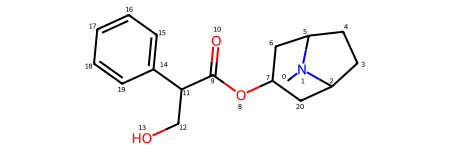

In [25]:
for atom in mol.GetAtoms():
    # For each atom, set the property "atomNote" to a index+1 of the atom
    atom.SetProp("atomNote", str(atom.GetIdx()))

display(mol)

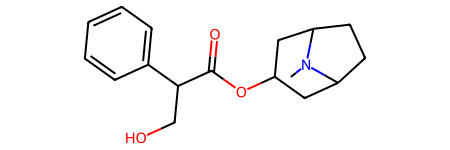

In [57]:
a = Chem.CanonSmiles("CN1C2CCC1CC(C2)OC(=O)C(CO)c3ccccc3")
b = Chem.MolFromSmiles(a)
b

# Test

0
1
2
3
4
5
6
7
8
9
10
11


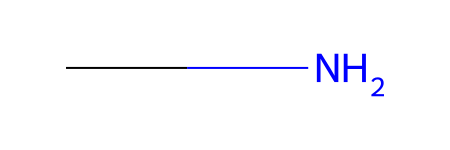

This is node 1 


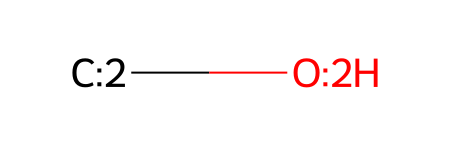

This is node 2 


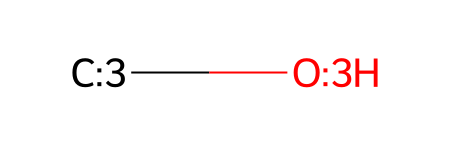

This is node 3 


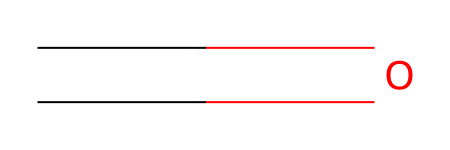

This is node 4 


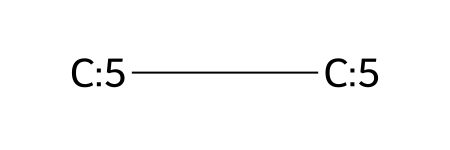

This is node 5 


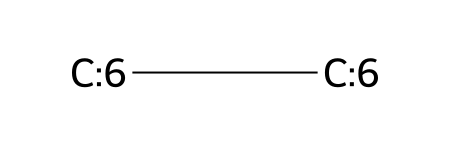

This is node 6 


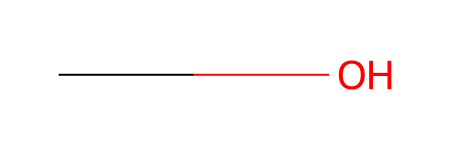

This is node 7 


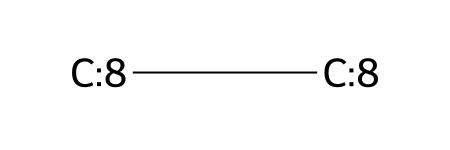

This is node 8 


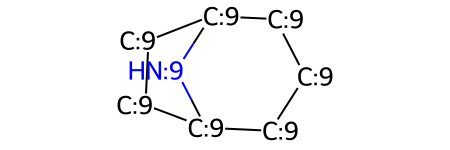

This is node 9 


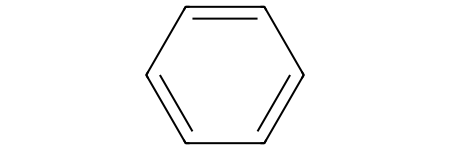

This is node 10 


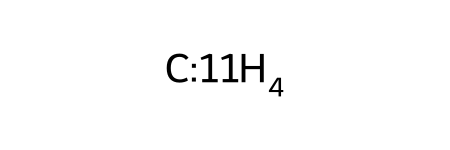

This is node 11 


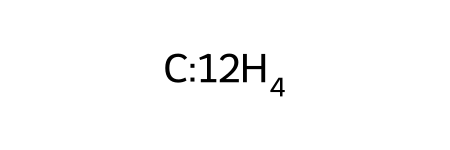

This is node 12 
This is node (centraol) 11 


'node neighbor of node 11 '

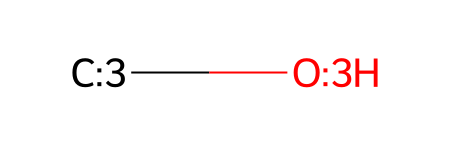

'node neighbor of node 11 '

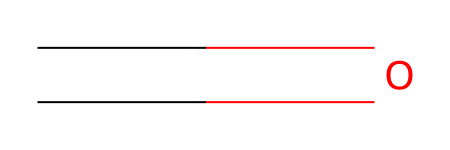

'node neighbor of node 11 '

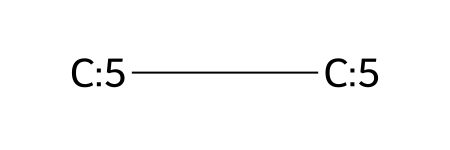

This is node (centraol) 12 


'node neighbor of node 12 '

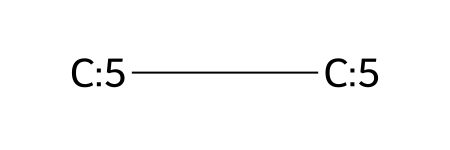

'node neighbor of node 12 '

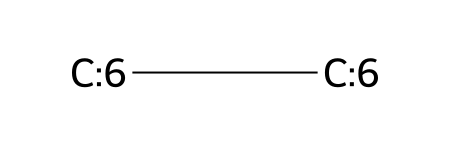

'node neighbor of node 12 '

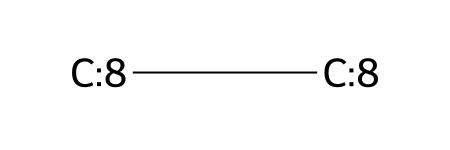

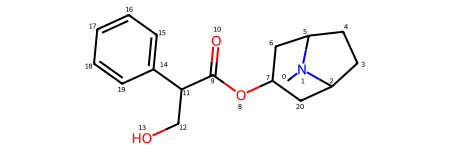

In [55]:
nodes = []

for i,c in enumerate(cliques):
    print(i)
    smiles = Chem.MolFragmentToSmiles(mol, c, kekuleSmiles=True)
    new_mol = Chem.MolFromSmiles(smiles, sanitize=False)
    new_mol = copy_edit_mol(new_mol).GetMol()
    new_mol = sanitize(new_mol) #We assume this is not None
    node = MolTreeNode(get_smiles(new_mol), c)
    nodes.append(node)
    if min(c) == 0: root = i                                        #finding root node by find clique contain atom has index 0 
for x,y in edges:                                                   #edge contain index of clique that connected
    nodes[x].add_neighbor(nodes[y])
    nodes[y].add_neighbor(nodes[x])    
if root > 0:                                                        #ensuring that the identified root node is positioned at index 0 in the self.nodes
    nodes[0],nodes[root] = nodes[root],nodes[0] #swaps the positions of these two nodes

for i,node in enumerate(nodes):
    node.nid = i + 1
    if len(node.neighbors) > 1: #Leaf node mol is not marked
        set_atommap(node.mol, node.nid)                             #Set the ID of each node (the mol of each clique), no neighbor = leaf
    # display(f"node neighbor of node {node.nid} ", node.neighbors[0].mol)
    display(node.mol)
    print(f"This is node {node.nid} ")

    node.is_leaf = (len(node.neighbors) == 1)

for nei_node in nodes[10:12]:
    print(f"This is node (centraol) {nei_node.nid} ")
    for i in nei_node.neighbors:
        display(f"node neighbor of node {nei_node.nid} ", i.mol)
    # cmol = get_clique_mol(self.mol, c)                              #get the mol of each clique
    # node = MolTreeNode(get_smiles(cmol), c)
    # nodes.append(node)
    # if min(c) == 0: root = i      
for atom in mol.GetAtoms():
    # For each atom, set the property "atomNote" to a index+1 of the atom
    atom.SetProp("atomNote", str(atom.GetIdx()))
display(mol) 

In [37]:
print(len(node[-1].neighbors))

TypeError: 'MolTreeNode' object is not subscriptable

In [ ]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

edges_check = defaultdict(int)

edges_check = {(0, 1): 1, (1, 12): 1, (2, 12): 1, (5, 12): 1, (2, 3): 1, (3, 9): 1, (9, 10): 2, (4, 9): 1, (5, 13): 1, (6, 13): 1, (7, 13): 1, (7, 8): 1, (8, 11): 1}
edges_list = [u + (MST_MAX_WEIGHT-v,) for u,v in edges_check.items()]
print(edges_list)
row,col,data = list(zip(*edges_list))
n_clique = len(cliques)
clique_graph = csr_matrix( (data,(row,col)), shape=(n_clique,n_clique) )
print(clique_graph)
junc_tree = minimum_spanning_tree(clique_graph)
print(junc_tree)
row,col = junc_tree.nonzero()
edges = [(row[i],col[i]) for i in range(len(row))]
# return (cliques, edges)

[(0, 1, 99), (1, 12, 99), (2, 12, 99), (5, 12, 99), (2, 3, 99), (3, 9, 99), (9, 10, 98), (4, 9, 99), (5, 13, 99), (6, 13, 99), (7, 13, 99), (7, 8, 99), (8, 11, 99)]
  (0, 1)	99
  (1, 12)	99
  (2, 3)	99
  (2, 12)	99
  (3, 9)	99
  (4, 9)	99
  (5, 12)	99
  (5, 13)	99
  (6, 13)	99
  (7, 8)	99
  (7, 13)	99
  (8, 11)	99
  (9, 10)	98
  (0, 1)	99.0
  (1, 12)	99.0
  (2, 3)	99.0
  (2, 12)	99.0
  (3, 9)	99.0
  (4, 9)	99.0
  (5, 12)	99.0
  (5, 13)	99.0
  (6, 13)	99.0
  (7, 8)	99.0
  (7, 13)	99.0
  (8, 11)	99.0
  (9, 10)	98.0


In [ ]:
print(edges)

[(0, 1), (1, 12), (2, 3), (2, 12), (3, 9), (4, 9), (5, 12), (5, 13), (6, 13), (7, 8), (7, 13), (8, 11), (9, 10)]


In [ ]:
row,col = junc_tree.nonzero()


In [ ]:
col

array([ 1, 12,  3, 12,  9,  9, 12, 13, 13,  8, 13, 11, 10], dtype=int32)

In [ ]:
def copy_atom(atom):
    new_atom = Chem.Atom(atom.GetSymbol())
    new_atom.SetFormalCharge(atom.GetFormalCharge())
    new_atom.SetAtomMapNum(atom.GetAtomMapNum())
    return new_atom
def sanitize(mol):
    try:
        smiles = get_smiles(mol)
        mol = get_mol(smiles)
    except Exception as e:
        return None
    return mol
def copy_edit_mol(mol):
    new_mol = Chem.RWMol(Chem.MolFromSmiles(''))
    for atom in mol.GetAtoms():
        new_atom = copy_atom(atom)
        new_mol.AddAtom(new_atom)
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()
        bt = bond.GetBondType()
        new_mol.AddBond(a1, a2, bt)
    return new_mol
def get_clique_mol(mol, atoms):
    smiles = Chem.MolFragmentToSmiles(mol, atoms, kekuleSmiles=True)
    new_mol = Chem.MolFromSmiles(smiles, sanitize=False)
    new_mol = copy_edit_mol(new_mol).GetMol()
    new_mol = sanitize(new_mol) #We assume this is not None
    return new_mol

C1=CN=CNC1


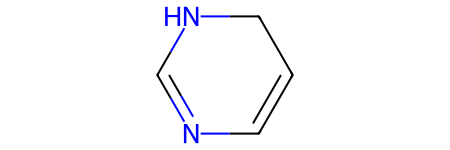

In [ ]:
smiles = Chem.MolFragmentToSmiles(mol, (5, 6, 11, 12, 14, 4), kekuleSmiles=True)
print(smiles)
new_mol = Chem.MolFromSmiles(smiles, sanitize=False)
new_mol = copy_edit_mol(new_mol).GetMol()
# new_mol = sanitize(new_mol) #We assume this is not None
new_mol


In [ ]:
neww_mol = sanitize(new_mol) #We assume this is not None
neww_mol

In [ ]:
class MolTreeNode(object):

    def __init__(self, smiles, clique=[]):
        self.smiles = smiles
        self.mol = get_mol(self.smiles)

        self.clique = [x for x in clique] #copy
        self.neighbors = []



    def add_neighbor(self, nei_node):
        self.neighbors.append(nei_node)

    def recover(self, original_mol):
        clique = []
        clique.extend(self.clique)
        if not self.is_leaf:
            for cidx in self.clique:
                original_mol.GetAtomWithIdx(cidx).SetAtomMapNum(self.nid)

        for nei_node in self.neighbors:
            clique.extend(nei_node.clique)
            if nei_node.is_leaf: #Leaf node, no need to mark 
                continue
            for cidx in nei_node.clique:
                #allow singleton node override the atom mapping
                if cidx not in self.clique or len(nei_node.clique) == 1:
                    atom = original_mol.GetAtomWithIdx(cidx)
                    atom.SetAtomMapNum(nei_node.nid)

        clique = list(set(clique))
        label_mol = get_clique_mol(original_mol, clique)
        self.label = Chem.MolToSmiles(Chem.MolFromSmiles(get_smiles(label_mol)))

        for cidx in clique:
            original_mol.GetAtomWithIdx(cidx).SetAtomMapNum(0)

        return self.label
    
    def assemble(self):
        neighbors = [nei for nei in self.neighbors if nei.mol.GetNumAtoms() > 1]
        neighbors = sorted(neighbors, key=lambda x:x.mol.GetNumAtoms(), reverse=True)
        singletons = [nei for nei in self.neighbors if nei.mol.GetNumAtoms() == 1]
        neighbors = singletons + neighbors

        cands,aroma = enum_assemble(self, neighbors)
        new_cands = [cand for i,cand in enumerate(cands) if aroma[i] >= 0]
        if len(new_cands) > 0: cands = new_cands

        if len(cands) > 0:
            self.cands, _ = list(zip(*cands))
            self.cands = list(self.cands)
        else:
            self.cands = []

In [ ]:
def get_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: 
        return None
    Chem.Kekulize(mol)
    return mol
node = MolTreeNode("C1=CN=CNC1", (5, 6, 11, 12, 14, 4))


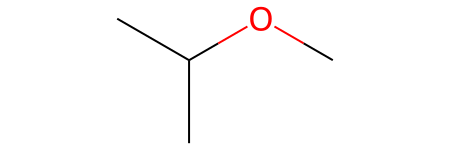